In [1]:
import torch
import torchvision

from  torchvision import transforms as tfms

print(torch.__version__)
print(torchvision.__version__)
print(torchvision.__path__)

1.10.1
0.11.0a0+0fc7abb
['/usr/lib/python3.10/site-packages/torchvision']


# Model
- yolov5n (nano) : 213 layers, 1867405 parameters
- yolov5s (small): 213 layers, 7225885 parameters

In [2]:
# Model:
#model = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=True)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /home/javi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-1-13 torch 1.10.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11175MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


## Random tensor as input

In [3]:
x = torch.rand(1, 3, 640, 640)
y = model(x)
y.shape

torch.Size([1, 25200, 85])

## Image as input

In [4]:
from PIL import Image, ImageFont, ImageDraw
import requests
from io import BytesIO

(1280, 720)


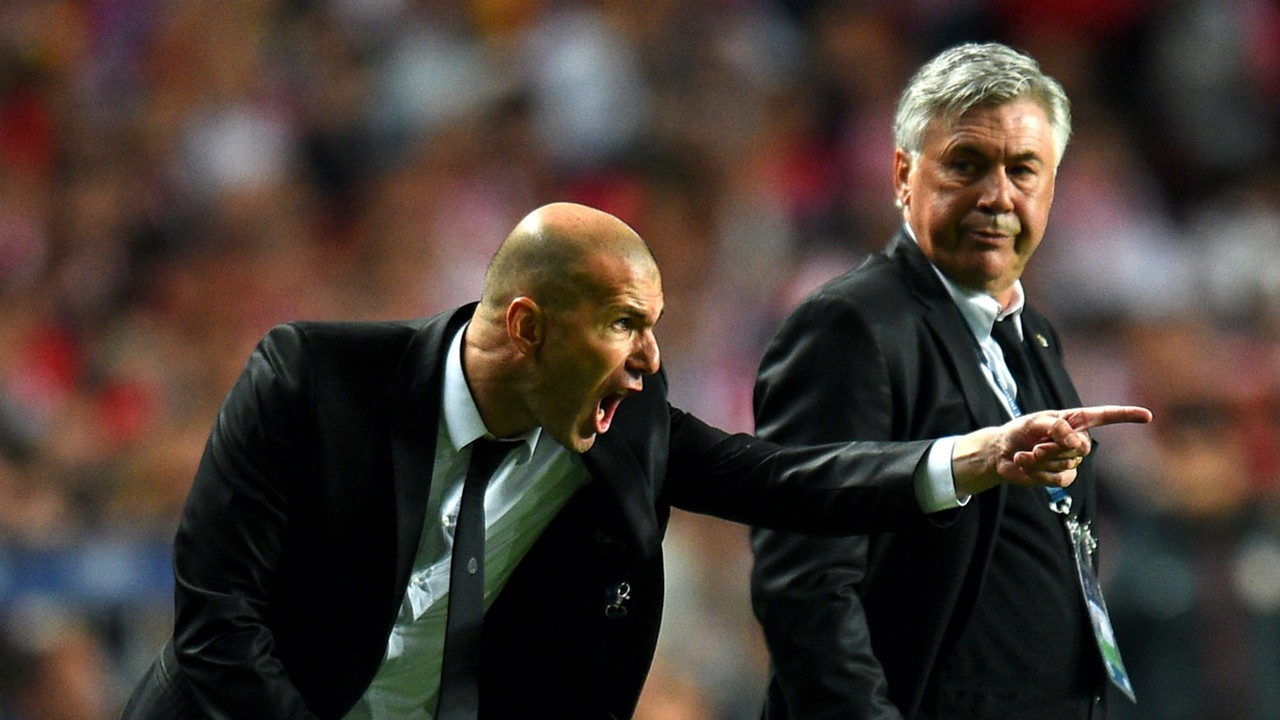

In [5]:
img_url = 'https://ultralytics.com/images/zidane.jpg'

response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
print(img.size)
img

In [6]:
transform = tfms.Compose(
    [tfms.Resize( size=(640,640) ),# tfms.CenterCrop(640),
     tfms.ToTensor(), # tfms.PILToTensor(), 0..255 to 0..1 NOTMALIZATION
     #tfms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # THIS MODEL DOES NOT NEED EXTRA NORMALIZATION
    ])
transform

Compose(
    Resize(size=(640, 640), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [7]:
img_tensor = transform(img)
img_tensor.shape

torch.Size([3, 640, 640])

In [8]:
img_tensor = img_tensor[None, :]
img_tensor.shape

torch.Size([1, 3, 640, 640])

In [9]:
pred = model(img_tensor)
pred.shape

torch.Size([1, 25200, 85])

## Visualize output

| 0 | 1 | 2 | 3 | 4 | rest (5...84)  |
|---|---|---|---|---|----------------|
| X | Y | W | H | P | on hot classes |

In [10]:
conf_thres = 0.2

candidates  = pred[..., 4] > conf_thres  # candidates
n_candidates = candidates.sum().item()

print("There are", n_candidates, "boxes with a confidence higher than", conf_thres)

There are 17 boxes with a confidence higher than 0.2


In [11]:
final_pred = pred[candidates]
final_pred.shape

torch.Size([17, 85])

In [12]:
x = final_pred[:,0]
y = final_pred[:,1]
w = final_pred[:,2]
h = final_pred[:,3]

l = (x - w / 2).int()
t = (y - h / 2).int()
r = (x + w / 2).int()
b = (y + h / 2).int()

In [13]:
img2 = img.resize((640,640))
#img2 = img.resize((1280, 720))
draw = ImageDraw.Draw(img2)
for c in range(n_candidates):
    draw.rectangle(((l[c], t[c]), (r[c], b[c])), width=3)

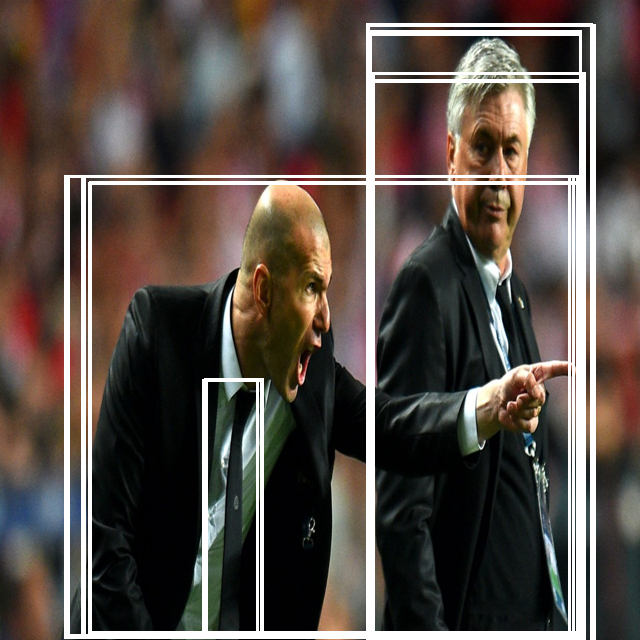

In [14]:
img2

## Delete repeated boxes (Non Max Supr)

In [15]:
iou_thres = 0.45